<h1> Байесовский классификатор </h1>
В машинном обучении — семейство простых вероятностных классификаторов, основанных на использовании теоремы Байеса и «наивном» предположении о независимости признаков классифицируемых объектов.
По сути, байесовский классификатор представляет собой вероятностную модель. Пусть задано множество наблюдений, каждое из которых представлено вектором признаков 
$x=(x_1,x_2,...,x_n)$. Модель присваивает каждому наблюдению условную вероятность $p(y_{k}|x_1,x_2,...,x_n)$, k — класс. <br>
<h2>$p(y_{k}|x) = \frac{p(y_{k})p(x|y_{k})}{p(x)}$ </h2> <br>
$p(y) $ - априорная вероятность класса yk <br>
$p(x|y_{k}) $ - функция правдоподобия класса yk <br>
$p(y_{k}|x) $ - апостериорная вероятность класса yk <br>

В этой формуле интерес с точки зрения классификации представляет только числитель, поскольку знаменатель от метки классов не зависит и является константой. 
При условии, что признаки независимы, можно показать, что
$p(y_k|x_1,x_2,...,x_n)=p(y_k)p(x_1|y_k)p(x_2|y_k)...p(x_n|y_k)=\prod_n p(x_i|y_k)$ <br>
Тогда простой байесовский классификатор можно рассматривать как функцию, которая каждому выходному значению 
модели присваивает метку класса, т.е. 
$a(x) = y_k следующим образом:$ <br>
<h2>$a(x) = arg_k max_{1...k} \prod_n p(x_i|y_k)$ </h2> <br>

Таким образом, выбирается класс $y_k$, который максимизирует функцию правдоподобия, представляющую собой произведение 
условных вероятностей значений признака $x_i$ по каждому классу $y_k$. <br>
Вероятностный классификатор предсказывает класс с самой большой условной вероятностью для заданного вектора признаков x.






<center> <img src="img/NB2.png", width="600">

__Востановления плотности по импирическим данным__

Истинное распределение р(х|у) не известно, востановим данную плотность $\hat{р}(х|у,Х) $

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.image import imread 
from mpl_toolkits import mplot3d 
from matplotlib import gridspec 
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet
from mixturelib.mixture import MixtureEM

import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from scipy import stats
import numpy as np
from sklearn import tree, base
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier) 
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve 
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression, load_wine
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from torchvision import datasets, transforms 
import torch

In [3]:
#Сгенерируем распределение
np.random.seed(42)
l=10000
p_x_1 = stats.norm(-1,0.5) 
x_1 = np.sqrt(0.5)*np.random.randn(l)-1
p_x_2 = stats.norm(1, 1.5)
x_2 = np.sqrt(1.5)*np.random.randn(l)+1

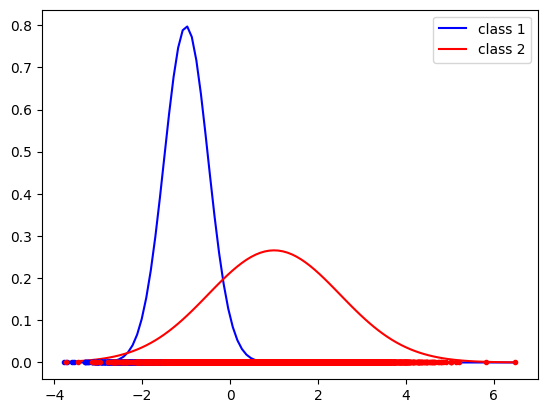

In [4]:
#Построим графики x - объект у- плотность вероятности
x = np.linspace(min(np.min(x_1), np.min(x_2)),
            max(np.max(x_1), np.max(x_2)), 100)
plt.plot(x, p_x_1.pdf(x), color='blue', label='class 1')
plt.plot(x, p_x_2.pdf(x), color='red', label='class 2')
plt.plot(x_1, x_1*0,'.', color='blue')
plt.plot(x_2, x_2*0,'.',color='red')
plt.legend(loc='best')
plt.show()


In [5]:
# Определяем величину плотности вероятности на интервале около точки x  используется метрика Минковского  metric='minkowski'
def p(x, D, h = 0.2): 
    D = np.array(D) 
    x = np.array(x)
    l = len(D) 
    n = 1
    if len(D.shape) == 2: 
        n = D.shape[1]
    D = D.reshape([-1, n])
    x = x.reshape([-1, n])
    return (1/(2*h))*(1/len(D))*(cdist(D, x, metric='minkowski', p=1) <= h).sum(axis=0)

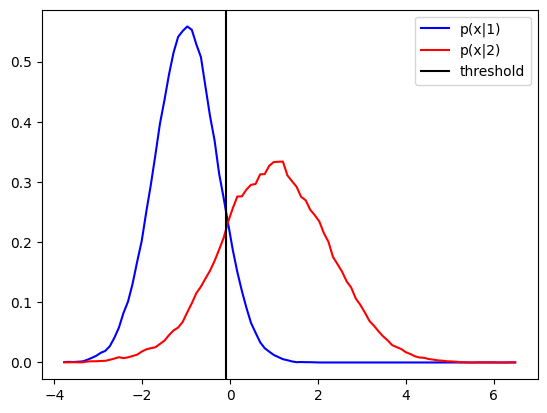

In [6]:
# Строим востанавливающую модель 
x = np.linspace(min(np.min(x_1), np.min(x_2)),
            max(np.max(x_1), np.max(x_2)), 100)
plt.plot(x, p(x, x_1), color ='blue', label = 'p(x|1)')
plt.plot(x, p(x, x_2), color = 'red', label ='p(x|2)')

plt.axvline(-0.1, color = 'black', label = 'threshold')

plt.legend(loc='best') 
plt.show()

__Смесь распределений__

In [7]:
color = ['blue', 'red']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device


device(type='cpu')

In [8]:
np.random.seed(42)
N = 200
noise_component = 0.8 
noise_target = 5

X = np.random.randn(N, 2)
X[:N//2, 1] *= noise_component 
X[:N//2] += np.array([-2,-2])
X[N//2:, 0] *= noise_component 
X[N//2:] +- np.array([2,2])

real_first_w = np.array([[10.], [0.]]) 
real_second_w = np.array([[0.], [30.]])
y = np.vstack([X[:N//2]@real_first_w, X[N//2:]@real_second_w]) + noise_target*np.random.randn(N, 1)

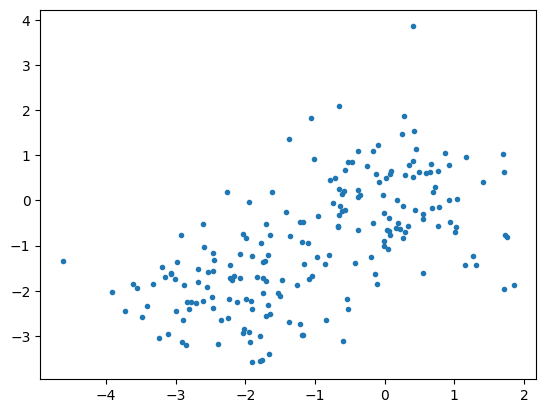

In [9]:
plt.plot(X[:, 0], X[ :, 1], '.')
plt.show()

In [10]:
torch.random.manual_seed(42) 
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(y)

In [11]:
#Первая и вторам модели
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
secode_model = EachModelLinear(input_dim=2)
list_of_models = [first_model, secode_model]

In [12]:
# Гипермодель
HpMd = HyperExpertNN(input_dim=2, hidden_dim=5, output_dim=2, epochs=100)

In [13]:
# Создание смеси
mixture = MixtureEM(HyperParameters={'beta': 1.}, 
                    HyperModel=HpMd, 
                    ListOfModels= list_of_models, 
                    model_type='sample')

In [14]:
# Обучение
List_of_ind=[]
List_of_W=[]
for _ in tqdm(range(10)):
    mixture.fit(X_tr, Y_tr, 1)
    List_of_ind.append(np.argmax(mixture.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in mixture.ListOfModels]))

List_of_ind = np.array(List_of_ind)
List_of_W = np.array(List_of_W)


  0%|          | 0/10 [00:00<?, ?it/s]

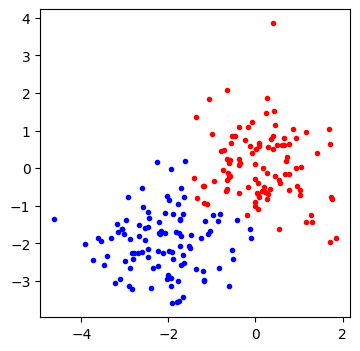

In [15]:
# Отображение
fig = plt.figure(figsize=(4.0, 4.0))
pred_type = np.argmax(mixture.predict(X_tr)[1], axis=-1) 
for i in np. unique (pred_type):
    plt.plot(X[pred_type==i, 0], X[pred_type==i, 1], '.', color=color[i], label= 'type {}'.format(i))

plt.show()

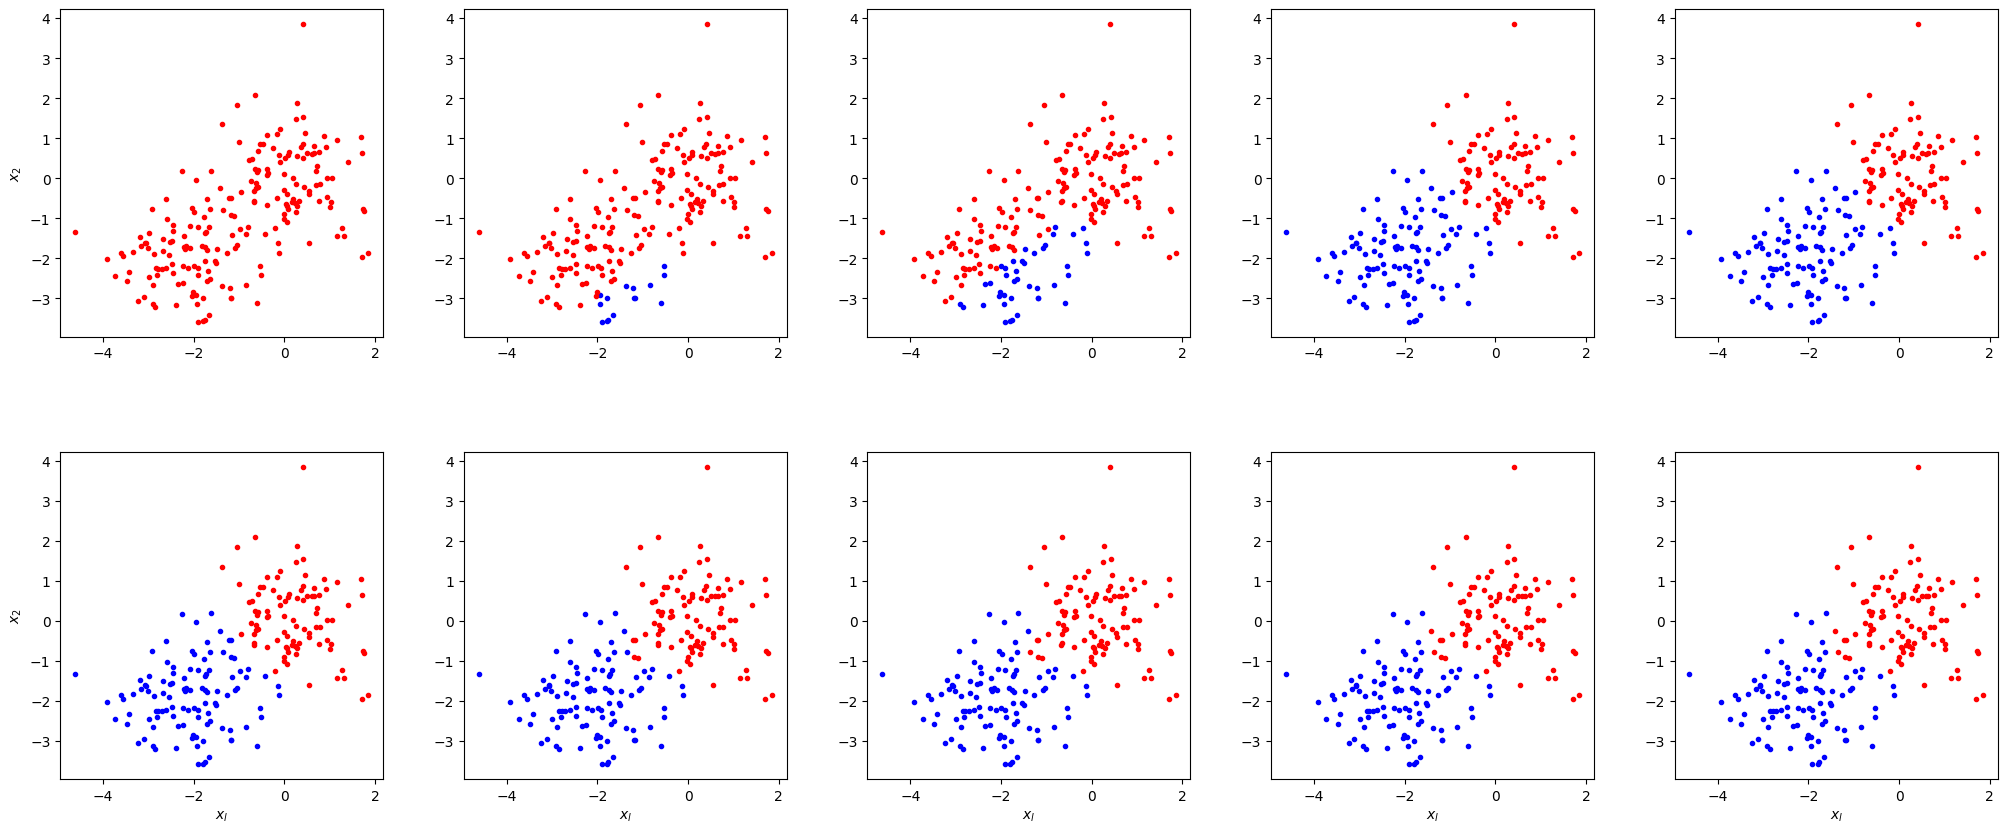

In [16]:
fig = plt.figure(figsize=(25.0, 10.0)) 
gs = gridspec.GridSpec(2, 5) 
ax = []

for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g)) 
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$') 
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_l$')

for e, (idx, _) in enumerate(zip(List_of_ind[:10], List_of_W[:10])): 
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35) 
plt.show()


Задание:
1. Изучить материал по ссылке:https://mixturelib.readthedocs.io/en/latest/info.html
2. Используя датасет по ирисам Фишера, с помощью байесовского классификатра 
    a) проивзести востановление плотности по данным;
    b) разделить ирисы на классы;
    с) Представить результат графически и найти точность.

Размерность данных X: (150, 4)
Названия классов: ['setosa' 'versicolor' 'virginica']
Названия признаков: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


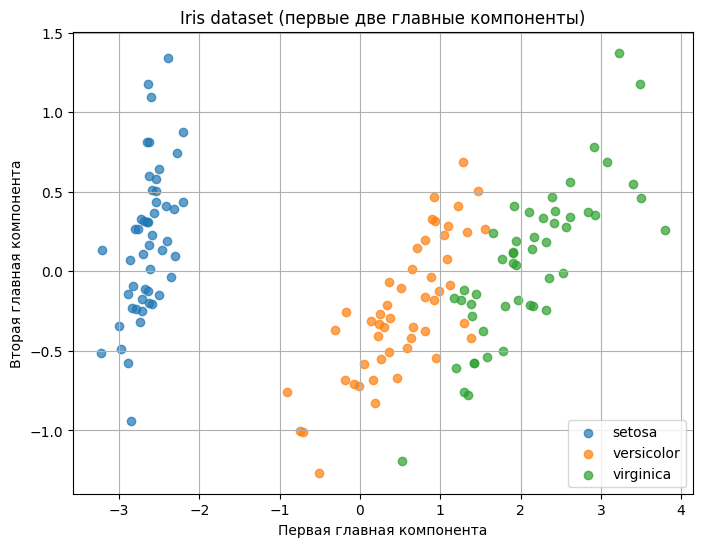


--- Шаг 2.a: Восстановление плотности ---
Восстанавливаем плотность p(x|y_k) для каждого класса и каждого признака...
(Это происходит внутри классификатора на этапе обучения)

--- Шаг 2.b и 2.c: Результаты классификации ---
Точность (Accuracy) на тестовой выборке: 0.9111


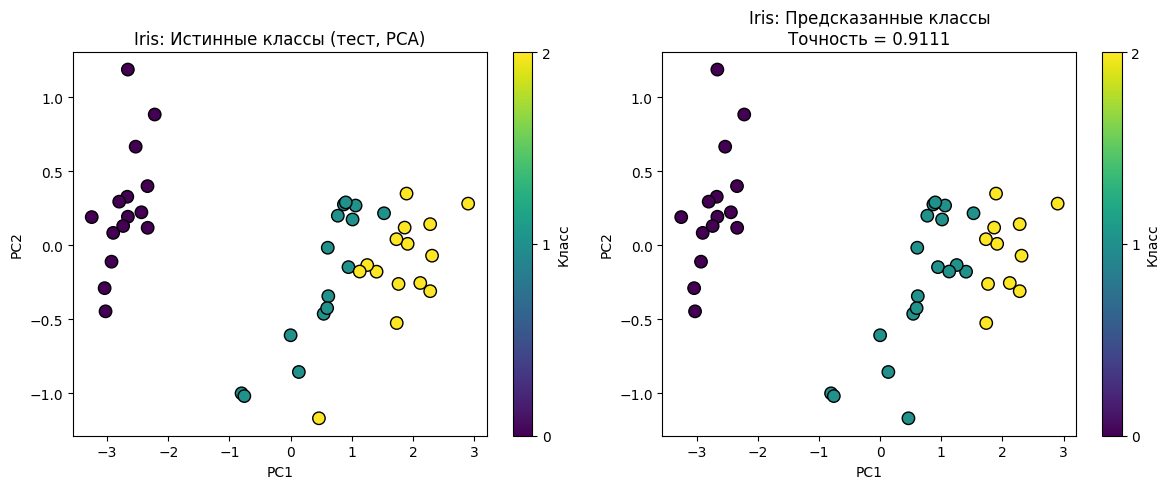


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



In [17]:
# Импортируем необходимые библиотеки
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Определим функцию p, если она еще не определена в сессии (из вашего ноутбука)
def p(x, D, h=0.5): # Немного увеличим окно h для более гладкой оценки
    """
    Оценка плотности методом Парзеновского окна.
    """
    D = np.array(D)
    x = np.array(x).reshape(-1, D.shape[1] if D.ndim > 1 else 1)
    if D.ndim == 1:
        D = D.reshape(-1, 1)
    n = D.shape[1]
    # Используем гауссово ядро вместо прямоугольного для гладкости
    # Но для простоты оставим прямоугольное, как в вашей функции
    return (1/(2*h)) * (1/len(D)) * (cdist(D, x, metric='minkowski', p=2) <= h).sum(axis=0) # p=2 для евклидова расстояния

# --- Загрузка данных Iris ---
iris = load_iris()
X = iris.data  # Признаки: длина и ширина чашелистика и лепестка
y = iris.target # Метки классов: 0, 1, 2
target_names = iris.target_names
feature_names = iris.feature_names

print("Размерность данных X:", X.shape)
print("Названия классов:", target_names)
print("Названия признаков:", feature_names)

# --- Визуализация исходных данных с помощью PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for i, target_name in enumerate(target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=target_name, alpha=0.7)
plt.title('Iris dataset (первые две главные компоненты)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Шаг 2.a: Восстановление плотности ---")
print("Восстанавливаем плотность p(x|y_k) для каждого класса и каждого признака...")
print("(Это происходит внутри классификатора на этапе обучения)")

# --- Шаг 2.b и 2.c: Разделение на классы, оценка точности и визуализация ---

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Обучаем PCA на обучающей выборке и преобразуем тестовую
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# --- Реализация наивного байесовского классификатора ---
class NaiveBayesWithDensity:
    def __init__(self, h=0.5):
        self.h = h
        self.classes_ = None
        self.priors_ = {}
        self.densities_ = {} # Словарь для хранения данных для оценки плотности

    def fit(self, X, y):
        """Обучение модели: вычисление априорных вероятностей и сохранение данных для оценки плотности."""
        self.classes_ = np.unique(y)
        for c in self.classes_:
            X_c = X[y == c]
            # Априорная вероятность класса
            self.priors_[c] = len(X_c) / len(X)
            # Сохраняем данные для каждого признака отдельно? Функция p работает со всем X_c.
            # Для простоты будем передавать все данные класса.
            self.densities_[c] = X_c
        return self

    def predict_proba(self, X):
        """Предсказание логарифма апостериорной вероятности для каждого класса."""
        log_probs = []
        for c in self.classes_:
            # Начинаем с log(приор)
            log_prior = np.log(self.priors_[c])
            # Оценка плотности для всех признаков сразу? Нет, NB требует произведение по признакам.
            # Функция p возвращает плотность для всего вектора? Нет, она возвращает плотность в точке x, используя все данные D.
            # Это не совсем верно для NB, где нужно произведение p(x_i|y_k).
            # Восстановим плотность для каждого признака отдельно.
            log_likelihood_sum = 0
            for feature_idx in range(X.shape[1]): # Цикл по признакам
                 # Данные класса c для конкретного признака feature_idx
                D_feature = self.densities_[c][:, feature_idx]
                 # Значение признака x для всех объектов в X
                x_feature = X[:, feature_idx]
                 # Оценка плотности p(x_i|y_k) с использованием вашей функции p
                p_vals = p(x_feature, D_feature, h=self.h)
                 # Добавляем логарифм, избегая log(0)
                p_vals = np.clip(p_vals, 1e-10, None) # Не даем уйти в ноль
                log_likelihood_sum += np.log(p_vals)
            log_probs.append(log_prior + log_likelihood_sum)
        return np.array(log_probs).T

    def predict(self, X):
        """Предсказание метки класса."""
        log_probs = self.predict_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]

# Создаем и обучаем классификатор
# Для многомерных данных h нужно подбирать. Попробуем побольше, так как данных мало.
nb_classifier = NaiveBayesWithDensity(h=1.5)
nb_classifier.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = nb_classifier.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Шаг 2.b и 2.c: Результаты классификации ---")
print(f"Точность (Accuracy) на тестовой выборке: {accuracy:.4f}")

# Визуализация предсказаний на тестовой выборке в PCA-пространстве
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', edgecolors='k', s=80)
plt.title('Iris: Истинные классы (тест, PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(ticks=[0, 1, 2], label='Класс')

plt.subplot(1, 2, 2)
sc = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', edgecolors='k', s=80)
plt.title(f'Iris: Предсказанные классы\nТочность = {accuracy:.4f}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(sc, ticks=[0, 1, 2], label='Класс')

plt.tight_layout()
plt.show()

# Выведем отчет по классам для более детального анализа
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))